# Preprocessing the Data

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("Delhi Air Quality Data.csv",usecols=['Datetime','AQI'],parse_dates=['Datetime'])
df.set_index('Datetime',inplace=True)

In [2]:
df.head(20)

,AQI
Datetime,
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
2015-01-01 05:00:00,NaN
2015-01-01 06:00:00,NaN
2015-01-01 07:00:00,NaN
2015-01-01 08:00:00,NaN
2015-01-01 09:00:00,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48192 entries, 2015-01-01 01:00:00 to 2020-01-07 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     47694 non-null  float64
dtypes: float64(1)
memory usage: 753.0 KB


In [4]:
df = df.fillna(method='bfill')

In [5]:
# Functions to calculate RMSE and MAPE scores

from sklearn import metrics
def calculateRMSE(x,y):
    return (metrics.mean_squared_error(x,y))**0.5

def calculateMAPE(x,y):
    return (100/len(x))*sum(np.abs([(x[i]-y[i])/x[i] for i in range(len(x))]))


# Function for Theil's U-1 Statistic score

def theils(x,y):
    y = y
    x = x
    df = pd.DataFrame({'X':x, 'Y': y})
    df['(X - Y)^2'] = np.square(df['X'] - df['Y'])
    df['Y^2'] = np.square(df['Y'])
    df['X^2'] = np.square(df['X'])
    return (np.sqrt(np.mean(df['(X - Y)^2'])))/(np.sqrt(np.mean(df['Y^2']))+np.sqrt(np.mean(df['X^2'])))

### Visualize Time Series Data

Text(0.5, 1.0, 'Delhi Hourly AQI from 2015-01-01 01:00:00 to 2020-12-06 23:00:00')

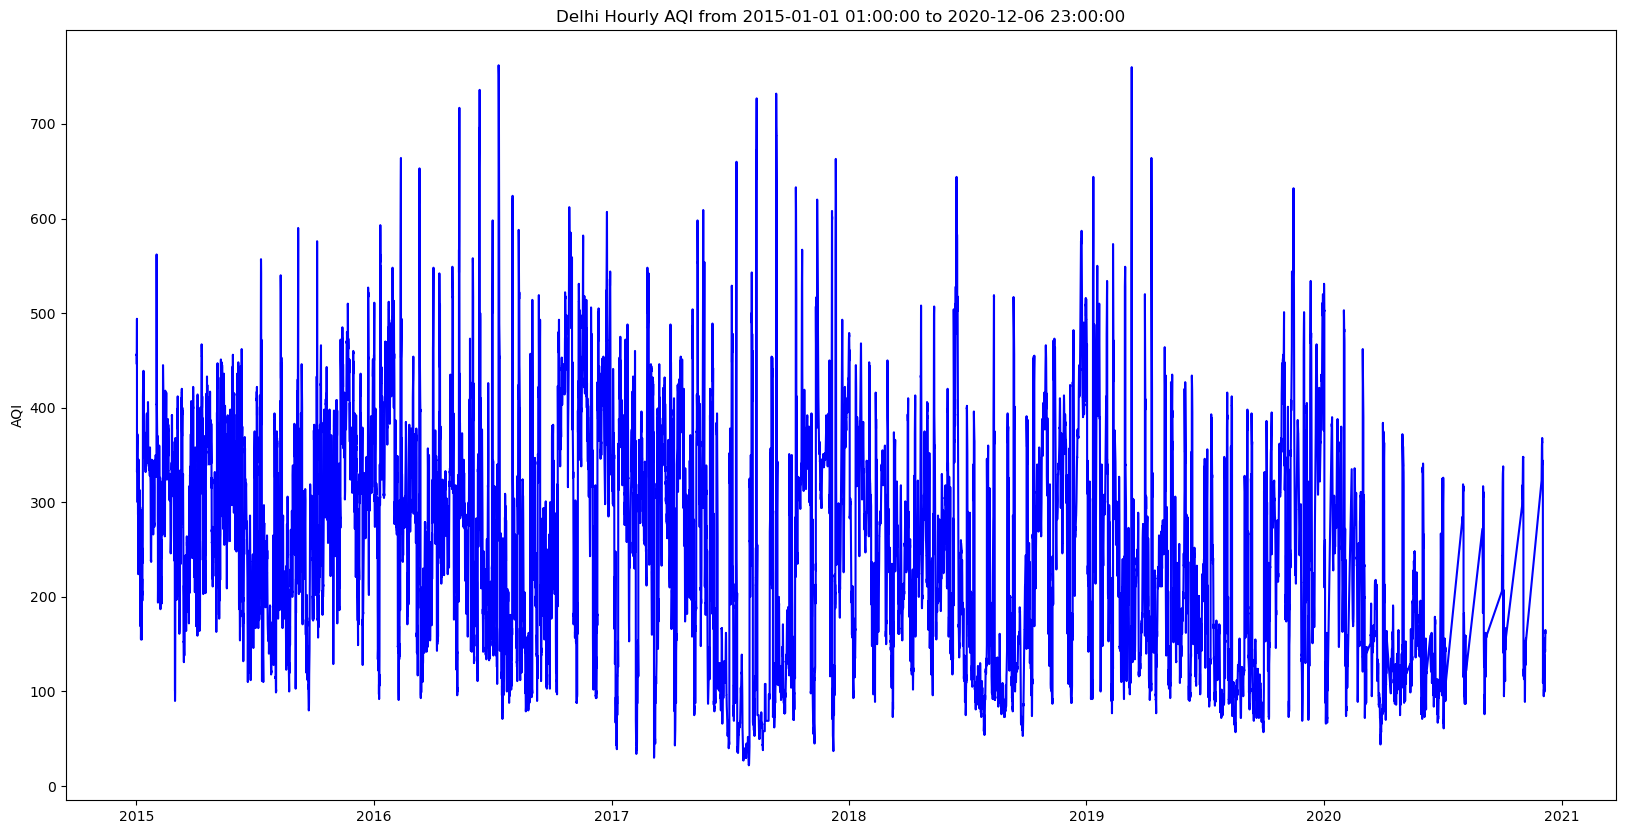

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df.sort_values('Datetime',inplace=True)
plt.figure(figsize=(20, 10))
plt.plot(df.index,df.AQI,color='b')
#plt.xlabel('Hour')
plt.ylabel('AQI')
plt.title('Delhi Hourly AQI from '+str(df.index[0])+" to "+str(df.index[-1]))

## QRNN


In [32]:
#step 2: preprocessing
#B) Scaling
from sklearn.preprocessing import MinMaxScaler

values = df[df.columns[[0]]].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.5864865 ],
       [0.5864865 ],
       [0.5864865 ],
       ...,
       [0.19324324],
       [0.19324324],
       [0.1891892 ]], dtype=float32)

In [33]:
from numpy import array,arange

def split_sequence(sequence, lag, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps*lag
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[arange(i,i+(lag*n_steps),lag)], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [34]:
# choose a number of time steps
ED = 3
lag = 1
raw_seq = scaled
#raw_seq = dataset.Price
# split into samples
X, y = split_sequence(raw_seq, lag, ED)
X

array([[[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       [[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       [[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       ...,

       [[0.19189191],
        [0.19189191],
        [0.19324324]],

       [[0.19189191],
        [0.19324324],
        [0.19324324]],

       [[0.19324324],
        [0.19324324],
        [0.19324324]]], dtype=float32)

In [35]:
x=df.shape
rows=x[0]
import math
train_rows=math.ceil(rows*0.80)

train_X = X[0:(train_rows-(lag*ED)),:]
train_y = y[0:(train_rows-(lag*ED))]
test_X = X[(train_rows-(lag*ED)):rows,:]
test_y = y[(train_rows-(lag*ED)):rows]

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K

def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [38]:
qs = [0.1,0.5,0.9]
from sklearn import metrics

# reshape 
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))

test_y = scaler.inverse_transform(test_y.reshape(-1,1))
minmse = 10000000
bestquantile=0

for q in qs:
    print("Quantile = ",q)
    model = Sequential()
    model.add(Dense(units=10, input_dim=ED,activation='relu'))
    #model.add(Dense(units=ED, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(train_X, train_y, epochs=100, batch_size=50, verbose=1)
    
    # Predict the quantile
    y_predicted = model.predict(test_X).flatten()
    predictions = scaler.inverse_transform(y_predicted.reshape(-1,1))
    quantilemse = metrics.mean_squared_error(test_y,predictions)
    if quantilemse < minmse:
        minmse=quantilemse
        bestquantile=q
        bestpredictions = predictions

Quantile =  0.1
Epoch 1/100
772/772 [==============================] - 3s 3ms/step - loss: 0.0260
Epoch 2/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0253
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0243
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0232
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0221
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0209
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0196
Epoch 8/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0185
Epoch 9/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0175
Epoch 10/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0166
Epoch 11/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0158
Epoch 12/100
772/772 [==============================] - 2s 2ms/step - loss: 0.01

772/772 [==============================] - 2s 2ms/step - loss: 0.0036
Epoch 100/100
302/302 [==============================] - 1s 2ms/step
Quantile =  0.5
Epoch 1/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1896
Epoch 2/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1860
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1815
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1762
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1703
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1638
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1567
Epoch 8/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1492
Epoch 9/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1412
Epoch 10/100
772/772 [==============================] - 2s 2ms/step - loss: 0.1329
Epoch 11/100
772/772 [==

772/772 [==============================] - 2s 2ms/step - loss: 0.0170
Epoch 98/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0165
Epoch 99/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0159
Epoch 100/100
302/302 [==============================] - 1s 2ms/step
Quantile =  0.9
Epoch 1/100
772/772 [==============================] - 3s 2ms/step - loss: 0.5568
Epoch 2/100
772/772 [==============================] - 2s 3ms/step - loss: 0.5492
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 0.5396
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 0.5283
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 0.5156
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 0.5018
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4870
Epoch 8/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4714
Epoch 9/100
772/772 [==

772/772 [==============================] - 2s 2ms/step - loss: 0.0176
Epoch 96/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0175
Epoch 97/100
772/772 [==============================] - 2s 3ms/step - loss: 0.0175
Epoch 98/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0174
Epoch 99/100
772/772 [==============================] - 2s 2ms/step - loss: 0.0174
Epoch 100/100
302/302 [==============================] - 1s 2ms/step


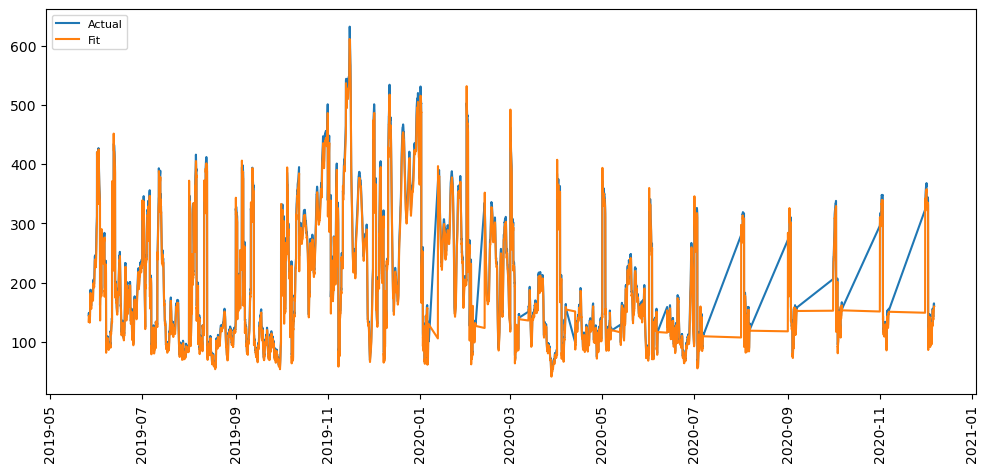

In [39]:
# Plot
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,5))

actual = test_y
time_index = df.iloc[train_rows:rows,:].index
plt.plot(time_index,actual, label='Actual')
plt.plot(time_index,bestpredictions, label='Fit')

degrees = 90
plt.xticks(rotation=degrees)
plt.legend(loc='upper left', fontsize=8)

In [40]:
rmse_qrnn = calculateRMSE(actual,bestpredictions)
mape_qrnn = calculateMAPE(actual,bestpredictions)

print("The RMSE of the QRNN model is ",rmse_qrnn)
print("The MAPE of the QRNN model is ",mape_qrnn)

theils_qrnn = theils(actual.flatten(),bestpredictions.flatten())

print("The Theil's U Statistic of the QRNN model is ",theils_qrnn)

The RMSE of the QRNN model is  19.64655650787658
The MAPE of the QRNN model is  [4.7390237]
The Theil's U Statistic of the QRNN model is  0.042714353844779084


## CNN

In [17]:
#step 2: preprocessing
#B) Scaling
from sklearn.preprocessing import MinMaxScaler

values = df[df.columns[[0]]].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.5864865 ],
       [0.5864865 ],
       [0.5864865 ],
       ...,
       [0.19324324],
       [0.19324324],
       [0.1891892 ]], dtype=float32)

In [18]:
from numpy import array,arange

def split_sequence(sequence, lag, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps*lag
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[arange(i,i+(lag*n_steps),lag)], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [19]:
# choose a number of time steps
ED = 3
lag = 1
raw_seq = scaled
#raw_seq = dataset.Rate
# split into samples
X, y = split_sequence(raw_seq, lag, ED)
X

array([[[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       [[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       [[0.5864865 ],
        [0.5864865 ],
        [0.5864865 ]],

       ...,

       [[0.19189191],
        [0.19189191],
        [0.19324324]],

       [[0.19189191],
        [0.19324324],
        [0.19324324]],

       [[0.19324324],
        [0.19324324],
        [0.19324324]]], dtype=float32)

In [21]:
x=df.shape
rows=x[0]
import math
train_rows=math.ceil(rows*0.80)

In [22]:
train_X = X[0:(train_rows-(lag*ED)),:]
train_y = y[0:(train_rows-(lag*ED))]
test_X = X[(train_rows-(lag*ED)):rows,:]
test_y = y[(train_rows-(lag*ED)):rows]

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D,MaxPooling1D

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(ED, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, train_y, epochs=200, verbose=2)

Epoch 1/200
1205/1205 - 4s - loss: 0.0019 - 4s/epoch - 3ms/step
Epoch 2/200
1205/1205 - 3s - loss: 9.3471e-04 - 3s/epoch - 2ms/step
Epoch 3/200
1205/1205 - 3s - loss: 9.2406e-04 - 3s/epoch - 2ms/step
Epoch 4/200
1205/1205 - 3s - loss: 9.1885e-04 - 3s/epoch - 2ms/step
Epoch 5/200
1205/1205 - 3s - loss: 9.0363e-04 - 3s/epoch - 2ms/step
Epoch 6/200
1205/1205 - 3s - loss: 8.8361e-04 - 3s/epoch - 2ms/step
Epoch 7/200
1205/1205 - 3s - loss: 8.7808e-04 - 3s/epoch - 2ms/step
Epoch 8/200
1205/1205 - 3s - loss: 8.6535e-04 - 3s/epoch - 2ms/step
Epoch 9/200
1205/1205 - 3s - loss: 8.4458e-04 - 3s/epoch - 2ms/step
Epoch 10/200
1205/1205 - 3s - loss: 8.5083e-04 - 3s/epoch - 2ms/step
Epoch 11/200
1205/1205 - 3s - loss: 8.4867e-04 - 3s/epoch - 2ms/step
Epoch 12/200
1205/1205 - 3s - loss: 8.5621e-04 - 3s/epoch - 2ms/step
Epoch 13/200
1205/1205 - 3s - loss: 8.5011e-04 - 3s/epoch - 2ms/step
Epoch 14/200
1205/1205 - 3s - loss: 8.4928e-04 - 3s/epoch - 2ms/step
Epoch 15/200
1205/1205 - 3s - loss: 8.5318e-04 

Epoch 120/200
1205/1205 - 3s - loss: 8.1223e-04 - 3s/epoch - 2ms/step
Epoch 121/200
1205/1205 - 2s - loss: 8.0987e-04 - 2s/epoch - 2ms/step
Epoch 122/200
1205/1205 - 2s - loss: 8.1095e-04 - 2s/epoch - 2ms/step
Epoch 123/200
1205/1205 - 3s - loss: 8.0883e-04 - 3s/epoch - 2ms/step
Epoch 124/200
1205/1205 - 3s - loss: 8.0703e-04 - 3s/epoch - 2ms/step
Epoch 125/200
1205/1205 - 3s - loss: 8.1263e-04 - 3s/epoch - 2ms/step
Epoch 126/200
1205/1205 - 2s - loss: 8.1007e-04 - 2s/epoch - 2ms/step
Epoch 127/200
1205/1205 - 3s - loss: 8.0814e-04 - 3s/epoch - 2ms/step
Epoch 128/200
1205/1205 - 3s - loss: 8.1132e-04 - 3s/epoch - 2ms/step
Epoch 129/200
1205/1205 - 2s - loss: 8.0886e-04 - 2s/epoch - 2ms/step
Epoch 130/200
1205/1205 - 2s - loss: 8.0970e-04 - 2s/epoch - 2ms/step
Epoch 131/200
1205/1205 - 3s - loss: 8.1342e-04 - 3s/epoch - 2ms/step
Epoch 132/200
1205/1205 - 3s - loss: 8.1243e-04 - 3s/epoch - 2ms/step
Epoch 133/200
1205/1205 - 2s - loss: 8.0796e-04 - 2s/epoch - 2ms/step
Epoch 134/200
1205/1

In [24]:
# demonstrate prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
yhat = model.predict(test_X, verbose=2)
print(yhat)

302/302 - 1s - 687ms/epoch - 2ms/step
[[0.1658828 ]
 [0.1728411 ]
 [0.17083183]
 ...
 [0.19437546]
 [0.19464135]
 [0.19407862]]


In [25]:
predictions = scaler.inverse_transform(yhat)
predictions

array([[144.75327],
       [149.9024 ],
       [148.41554],
       ...,
       [165.83783],
       [166.03459],
       [165.61818]], dtype=float32)

In [27]:
actual = scaler.inverse_transform(test_y)
actual

array([[145.     ],
       [146.     ],
       [146.99998],
       ...,
       [164.99998],
       [164.99998],
       [162.     ]], dtype=float32)

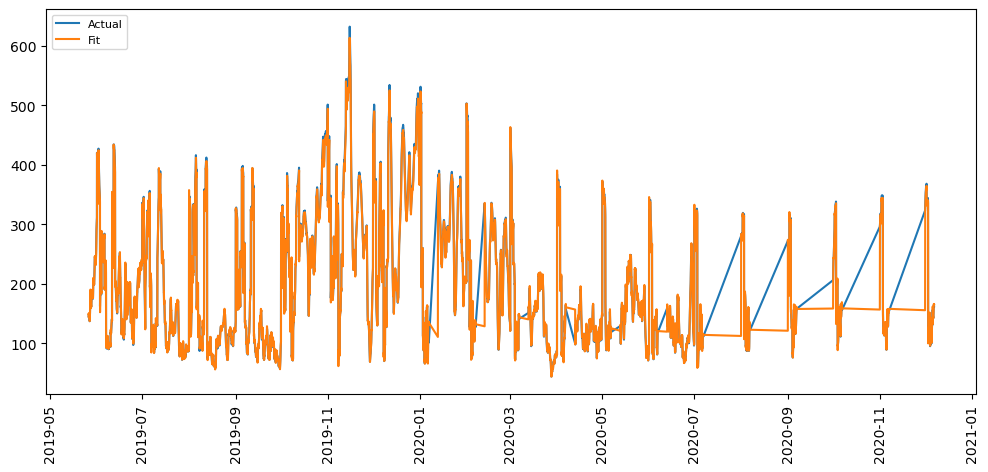

In [28]:
# Plot
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,5))

time_index = df.iloc[train_rows:rows,:].index
plt.plot(time_index,actual, label='Actual')
plt.plot(time_index,predictions, label='Fit')

degrees = 90
plt.xticks(rotation=degrees)
plt.legend(loc='upper left', fontsize=8)

In [31]:
rmse_cnn = calculateRMSE(actual,predictions)
mape_cnn = calculateMAPE(actual,predictions)

print("The RMSE of the CNN model is ",rmse_cnn)
print("The MAPE of the CNN model is ",mape_cnn)

theils_cnn = theils(actual.flatten(),predictions.flatten())

print("The Theil's U Statistic of the CNN model is ",theils_cnn)

The RMSE of the CNN model is  17.29905999777562
The MAPE of the CNN model is  [2.732814]
The Theil's U Statistic of the CNN model is  0.03721927110847361
